# Using New York City Taxi Data to illistrate using Arkouda with Pandas/NumPy

This notebook shows some examples of how to interoperate between Pandas and Arkouda at a small scale to allow it to be run on a 16GB laptop.
Remember, Arkouda is not trying to replace Pandas but to allow for some Pandas-style operation at a much larger scale. In our experience Pandas can handle dataframes up to about **500 million rows** before performance becomes a real issue, this is provided that you run on a sufficently capable compute server. Arkouda breaks the shared memory paradigm and scales its operations to dataframes with over **200 billion rows**, maybe even a trillion. In practice we have run Arkouda server operations on columns of one trillion elements running on 512 compute nodes. This yielded a **>20TB dataframe** in Arkouda.

- Import Arkouda package and connect to the Arkouda server
- import other useful packages
- Define some python helper functions for ETL (Extract/Transform/Load)
- Define a python function to transfer dataframes from Pandas to Arkouda
- Read NYC taxi csv into Pandas
- Put dataframe columns into the Arkouda server
- Compute taxi ride duration in Pandas and in Arkouda and histogram data
- Read NYC Taxi Zone Lookup Table (tzlut) into Pandas
- Transfer tzlut to Arkouda
- Compute something with Groupby/aggregate in Pandas and in Arkouda
  - Groupby on pickup and dropoff location ids
  - use groupby/aggregate on edge list to compute different things
    - min/max/mean/std distance between location ids
    - min/max/mean/std time between location ids
    - number of trips between location ids
    - other things
  - 
  - other things
- model number of taxis at a given time
- model taxis as specific entities (Kalman filter?)
  - use time and location ids
  - probability of paths of taxis
  - ...
- other things?

New York City Taxi Data
----------------------------------
[Yellow Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

[NYC Yellow Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv)

[Green Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

[NYC Green  Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2020-01.csv)

[NYC Taxi Zone Lookup Table](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv)

[NYC Taxi Zone Shapefile](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip)

### Import Arkouda package and connect to the server

In [1]:
import arkouda as ak
ak.connect(connect_url="tcp://MacBook-Pro.local:5555")

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: 2020.07.07


connected to arkouda server tcp://*:5555


### Import the other packages

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc

### Conversion functions for ETL

In [3]:
# conversion from csv field to int64
# try to convert to int, on exception (empty or other string) convert to 0
def cvt_to_int64(v):
    try:
        return np.int64(v)
    except:
        return np.int64(0)  

# conversion from csv field to string
# try to convert to int, on exception (empty or other string) convert to 0
def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

# conversion from csv field (Y,N,empty) to bool
# on Y convert to True, on N or empty convert to False
def cvt_YN_to_bool(v):
    if v == 'Y':
        return True
    else:
        return False

### Define function to transfer dataframe to dictionary of Arkouda arrays

In [4]:
# put data frame columns into arkouda server and return a dict of the pdarrays
# convert some columns into data types the server can understand
def ak_create_akdict_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname] = ak.from_series(df[cname])

    return akdict

### Helper functions

In [5]:
# returns minutes as a float 
def ns_to_min(v):
    return (v / (1e9 * 60.0))

# returns nanoseconds as an int
def min_to_ns(v):
    return (int(v * 1_000_000_000 * 60))

## Yellow taxi trip data

### Read in the data

In [6]:
# Read in yellow taxi data
# per yellow data dictionary convert to data types Arkouda can handle
# int64, float64, bool
cvt = {'VendorID': cvt_to_int64, 'passenger_count': cvt_to_int64, 'RatecodeID': cvt_to_int64,
       'store_and_fwd_flag': cvt_YN_to_bool,
       'PULocationID': cvt_to_int64, 'DOLocationID':cvt_to_int64, 'payment_type': cvt_to_int64}
# explicitly parse date-time fields
parse_dates_lst = ['tpep_pickup_datetime','tpep_dropoff_datetime']
# call read_csv to parse data with these options
ydf = pd.read_csv("./yellow_tripdata_2020-01.csv",
                  converters=cvt, header=0, low_memory=False,
                  parse_dates=parse_dates_lst, infer_datetime_format=True)

### Print out the dataframe

In [7]:
#print out dataframe
ydf

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.20,1,False,238,239,1,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.20,1,False,239,238,1,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.60,1,False,238,238,1,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1,0.80,1,False,238,151,1,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.00,1,False,193,193,2,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,0,2020-01-31 22:51:00,2020-01-31 23:22:00,0,3.24,0,False,237,234,0,17.59,2.75,0.5,0.00,0.00,0.3,21.14,0.0
6405004,0,2020-01-31 22:10:00,2020-01-31 23:26:00,0,22.13,0,False,259,45,0,46.67,2.75,0.5,0.00,12.24,0.3,62.46,0.0
6405005,0,2020-01-31 22:50:07,2020-01-31 23:17:57,0,10.51,0,False,137,169,0,48.85,2.75,0.0,0.00,0.00,0.3,51.90,0.0
6405006,0,2020-01-31 22:25:53,2020-01-31 22:48:32,0,5.49,0,False,50,42,0,27.17,2.75,0.0,0.00,0.00,0.3,30.22,0.0


### Which columns did we read in?

In [8]:
# see which keys we read in from first line of csv data file
#print(ydf.keys())
print(ydf.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')


### Convert the dataframe to a dictionary of Arkouda arrays

In [9]:
# put data frame columns into arkouda server
# convert some columns into data types the server can understand
akdict = ak_create_akdict_from_df(ydf)

### Show which columns got transfered to the Arkouda server 

In [10]:
# which keys made it over to the server
print(akdict.keys())

dict_keys(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge'])


### Look at the symbol table of the Arkouda server

In [11]:
# print out the arkouda server symbol table
print(ak.info(ak.AllSymbols))

name:"id_12" dtype:"float64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_13" dtype:"float64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_10" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_11" dtype:"float64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_7" dtype:"bool" size:6405008 ndim:1 shape:(6405008) itemsize:1
name:"id_6" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_5" dtype:"float64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_4" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_3" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_2" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_1" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_18" dtype:"float64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_9" dtype:"int64" size:6405008 ndim:1 shape:(6405008) itemsize:8
name:"id_8" dtype:"int64" size:640500

### Do a simple computation in the Arkouda server about pickup-time indexed logically by the store-and-forward flag

In [12]:
# how many records made it to the server?
numTotal = akdict['tpep_pickup_datetime'].size

# use the store_and_forward column to index tpep_pickup_datetime
# see how many times was false
numFalse = akdict['tpep_pickup_datetime'][~akdict['store_and_fwd_flag']].size

# use the store_and_forward column to index tpep_pickup_datetime
# see how many times was true
numTrue = akdict['tpep_pickup_datetime'][akdict['store_and_fwd_flag']].size

print(numTotal,numFalse,numTrue)
numTotal == numFalse+numTrue

6405008 6336888 68120


True

### Ride duration in Pandas

min =  -2770.366666666667 max =  8525.116666666667
mean =  15.950077949421253 stdev =  63.2299915764044
min_ride =  -2771
max_ride =  8526
11297 cnts      =  [1 0 0 ... 0 0 1]
11298 bin edges =  [-2770.36666667 -2769.36680092 -2768.36693517 ...  8523.11693517
  8524.11680092  8525.11666667]


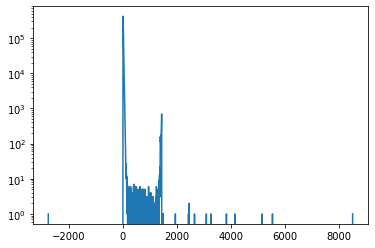

In [13]:
#Pandas ride duration 
ride_duration = ydf['tpep_dropoff_datetime'] - ydf['tpep_pickup_datetime']
# pull out ride duration in minutes
ride_duration = ride_duration.dt.total_seconds() / 60 # in minutes

print("min = ", ride_duration.min(),"max = ", ride_duration.max())
print("mean = ",ride_duration.mean(),"stdev = ",ride_duration.std())

# how long was the min/max ride to the next integer minute
min_ride = math.floor(ride_duration.min())
print("min_ride = ", min_ride)
max_ride = math.ceil(ride_duration.max())
print("max_ride = ", max_ride)

# histogram the ride time bin by the minute
nBins = max_ride - min_ride
cnts,binEdges = np.histogram(ride_duration, bins=nBins)

print(cnts.size,    "cnts      = ", cnts)
print(binEdges.size,"bin edges = ", binEdges)

# plot the histogram the ride time, bin by the minute
plt.plot(binEdges[:-1],cnts)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### Ride duration in Arkouda

min =  -2770.366666666667 max =  8525.116666666667
mean =  15.95007794942138 stdev =  63.22998664038934
min_ride =  -2771
max_ride =  8526
[-2770.36666667 -2769.36680092 -2768.36693517 ...  8523.11693517
  8524.11680092  8525.11666667]
11297 cnts      =  [1 0 0 ... 0 0 1]
11298 bin edges =  [-2770.36666667 -2769.36680092 -2768.36693517 ...  8523.11693517
  8524.11680092  8525.11666667]


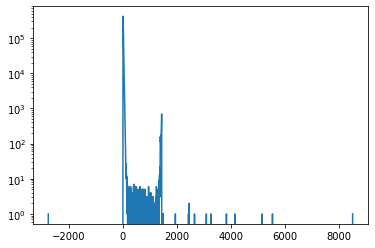

In [18]:
# take delta for ride duration
ride_duration = akdict['tpep_dropoff_datetime'] - akdict['tpep_pickup_datetime']
# pull out ride duration in minutes
ride_duration = ns_to_min(ride_duration)

print("min = ", ride_duration.min(),"max = ", ride_duration.max())
print("mean = ",ride_duration.mean(),"stdev = ",ride_duration.std())

# how long was the min/max ride to the next integer minute
min_ride = math.floor(ride_duration.min())
print("min_ride = ", min_ride)
max_ride = math.ceil(ride_duration.max())
print("max_ride = ", max_ride)

# histogram the ride time bin by the minute
nBins = max_ride - min_ride
cnts = ak.histogram(ride_duration, bins=nBins)

# create bin edges because ak.histogram doesn't
binEdges = np.linspace(ride_duration.min(), ride_duration.max(), nBins+1)
print(binEdges)

print(cnts.size,    "cnts      = ", cnts)
print(binEdges.size,"bin edges = ", binEdges)

# plot the histogram the ride time, bin by the minute
plt.plot(binEdges[:-1],cnts.to_ndarray())
plt.yscale('log')
plt.xscale('linear')
plt.show()

### Compute somehting with trip distance in Pandas

-30.62 210240.07
2.9296439333096878 83.15910597325029


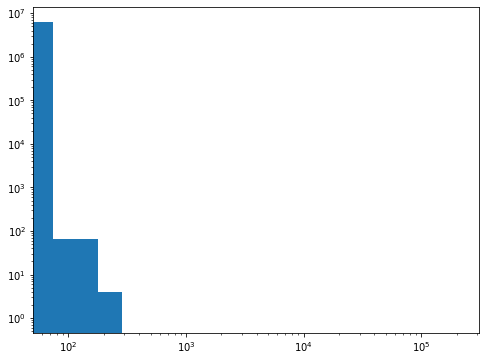

In [19]:
print(ydf['trip_distance'].min(), ydf['trip_distance'].max())
print(ydf['trip_distance'].mean(), ydf['trip_distance'].std())

plt.figure(figsize=(8,6))
plt.hist(ydf['trip_distance'],bins=2000)
#ax = plt.gca()
#ax.set_xlim((ydf['trip_distance'].min(),ydf['trip_distance'].max()))
plt.yscale('log')
plt.xscale('log')
plt.show()

### Compute somehting with trip distance in Arkouda

## Taxi Zone Lookup Table

### Read in the data

In [20]:
# read the taxi-zone-lookup-table
cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service_zone':cvt_to_string}
tzlut = pd.read_csv("/Volumes/Crucial X8/Data/NYC_taxi/taxi+_zone_lookup.csv",converters=cvt)
#tzlut = pd.read_csv("../Downloads/taxi+_zone_lookup.csv")
# print out the tzlut which was read from file
print(tzlut)

# location id is 1-based, index is 0-based
# fix it up to be aligned with index in data frame
# which means add row zero
top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'Zone': ['N/A'], 'service_zone': ['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop = True)
# print fixed up tzlut
print(tzlut)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Crucial X8/Data/NYC_taxi/taxi+_zone_lookup.csv'

### Convert dataframe to dictionary of Arkouda arrays

In [ ]:
# convert data frame with strings and int64 data
aktzlut = ak_create_akdict_from_df(tzlut)

### what did we get on the server side

In [ ]:
print(aktzlut)

### GroupBy pickup and dropoff location id
- Compute something with Groupby/aggregate in Pandas and in Arkouda
  - Groupby on pickup and dropoff location ids

In [ ]:
# groupby puckup(PU) and dropoff(DO) location ids(LID)
byLIDs = ak.GroupBy((akdict['PULocationID'], akdict['DOLocationID']))
# print unique keys
print('unique_keys (PU,DO): ', byLIDs.unique_keys)

### Use groupby/aggregate on edge list to construct a condensed graph

In [ ]:
# create a condensed graph of LID (PU,DO) pairs with different weights
graphLID = {}
 # vertex names (integer)
graphLID['V']    = aktzlut['LocationID']
# unique edges
graphLID['E']    = byLIDs.unique_keys
# edge weight: count of each unique edge
graphLID['W_CT'] = byLIDs.count()[1]
# edge weight: mean trip distance per edge
graphLID['W_TD'] = byLIDs.mean(akdict['trip_distance'])[1]
# edge weight: mean ride duration per edge
graphLID['W_RD'] = byLIDs.mean(ride_duration)[1]
# edge weight: mean fare amount per edge
graphLID['W_FA'] = byLIDs.mean(akdict['fare_amount'])[1]
# print the graph
print("graphLID = ", graphLID)

### Compute something with the condensed graph

In [ ]:
# Compute something with the condensed graph...


### Use join-on-eq-with-dt to look at adjacent trips
This is one of the most complex operations available in Arkouda and it's not well documented ;-)

- `ak.join_on_eq_with_dt(a1, a2, t1, t1, dt, pred, result_limit=1000)`
- this function finds places where the first two integer arrays are equal value then uses the predicate to test the second two arrays, if all is true then append indices to result list
- so, `if ((a1[i] == a2[j]) and predicate(t1[i],t2[j])) then add (i,j) to the result list`
- the `pred` can be `'true_dt'`, `'pos_dt'`, `'abs_dt'`
  - `'true_dt'` evaluates to `True` always
  - `'pos_dt'` evaluates `((t1     <= t2) && (t2 <= (t1+dt)))`
  - `'abs_dt'` evaluates `((t1-dt) <= t2) && (t2 <= (t1+dt)))`
- the `result_limit` makes sure you can handle the memory footprint of the result, this isn't implemented well right now in the multi-locale context


you can think of this as emitting 2-long chains from the line-graph of edges(trips) where the predicate is true

so trip1.DOLocationID is the same as trip2.PULocationID
and the second trip happens within time related to the first trip


In [ ]:
# ak.join_on_eq_with_dt(a1, a2, t1, t1, dt, pred, result_limit=1000)
#
# you can think of this as emitting 2-long chains from the line-graph of trips where the predicate is true
# so trip1.DOLocationID is the same as trip2.PULocationID
# and the second trip happens within time related to the first trip
#
(I,J) = ak.join_on_eq_with_dt(akdict['DOLocationID'], akdict['PULocationID'],
                              akdict['tpep_dropoff_datetime'], akdict['tpep_pickup_datetime'],
                              min_to_ns(1), 'pos_dt', result_limit=1_000_000)
print(I.size,I,J.size,J)

  - use join-with-dt
  - other things
- model number of taxis at a given time
- model taxis as specific entities (Kalman filter?)
  - use time and location ids
  - probability of paths of taxis
  - ...
- other things?

### disconnect from the server or shutdown the server

In [27]:
# disconnect or shutdown the server
ak.shutdown()
ak.disconnect()

disconnected from arkouda server tcp://*:5555


RuntimeError: not connected, cannot shutdown server